# Data Story: "The Anatomy of a Hit Movie"

In [57]:
import pandas as pd
import requests
import gzip
import shutil
import os

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# IMDb dataset URLs
base_url = "https://datasets.imdbws.com/"
files = [
    "title.basics.tsv.gz", "title.crew.tsv.gz", 
     "title.ratings.tsv.gz"
]

In [ ]:
# getting files and extratcting data
for file in files:
    response = requests.get(base_url + file, stream=True)
    with open(file, "wb") as f:
        f.write(response.content)
    
    with gzip.open(file, "rb") as f_in, open(file[:-3], "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)
    
    os.remove(file)  # Remove compressed file

# loading individual datasets
title_basics = pd.read_csv("title.basics.tsv", sep='\t', dtype=str, na_values='\\N')
title_crew = pd.read_csv("title.crew.tsv", sep='\t', dtype=str, na_values='\\N')

title_ratings = pd.read_csv("title.ratings.tsv", sep='\t', dtype=str, na_values='\\N')

# merging datasets
df = title_basics.merge(title_ratings, on="tconst", how="left")
df = df.merge(title_crew, on="tconst", how="left")

# saving to csv
df.to_csv("imdb_combined2.csv", index=False)

In [59]:
df = pd.read_csv("imdb_combined2.csv")


/var/folders/rn/rs1b20t55p5814zcnfn4wdjc0000gn/T/ipykernel_45013/3250846377.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("imdb_combined2.csv")


In [60]:
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers
0,tt0000001,short,Carmencita,Carmencita,0.0,1894.0,NaN,1.0,"Documentary,Short",5.7,2128.0,nm0005690,NaN
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0.0,1892.0,NaN,5.0,"Animation,Short",5.6,286.0,nm0721526,NaN
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0.0,1892.0,NaN,5.0,"Animation,Comedy,Romance",6.5,2163.0,nm0721526,NaN
3,tt0000004,short,Un bon bock,Un bon bock,0.0,1892.0,NaN,12.0,"Animation,Short",5.3,183.0,nm0721526,NaN
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0.0,1893.0,NaN,1.0,Short,6.2,2891.0,nm0005690,NaN


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 705640 entries, 8 to 11435167
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          705640 non-null  object 
 1   titleType       705640 non-null  object 
 2   primaryTitle    705638 non-null  object 
 3   originalTitle   705638 non-null  object 
 4   isAdult         705640 non-null  float64
 5   startYear       705640 non-null  int64  
 6   endYear         0 non-null       float64
 7   runtimeMinutes  444255 non-null  float64
 8   genres          629353 non-null  object 
 9   averageRating   705640 non-null  float64
 10  numVotes        324484 non-null  float64
 11  directors       630622 non-null  object 
 12  writers         537450 non-null  object 
dtypes: float64(5), int64(1), object(7)
memory usage: 75.4+ MB


In [ ]:
#checking total missing values
print(df.isnull().sum())

In [44]:
# Filter to only include movies (titleType = 'movie')
df = df[df['titleType'] == 'movie']

In [45]:
# Convert columns to numeric
df['averageRating'] = pd.to_numeric(df['averageRating'], errors='coerce')
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')
df['numVotes'] = pd.to_numeric(df['numVotes'], errors='coerce')
df['startYear'] = df['startYear'].fillna(0).astype(int)

# Imputation Technqiue 

In [47]:
# all columns with all missing values
missing_cols = X.columns[X.isna().all()]

# impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns.drop(missing_cols))

# add back the dropped columns with NaNs
for col in missing_cols:
    X_imputed[col] = np.nan

# ensure no NaNs or infinite values remain
X_imputed = X_imputed.replace([np.inf, -np.inf], np.nan).dropna()

# update X
X = X_imputed

# Print the first few rows to check
print(X.head())


   isAdult  startYear  runtimeMinutes  numVotes
0      0.0     1894.0            45.0     218.0
1      0.0     1897.0           100.0     549.0
2      0.0     1905.0           100.0      20.0
3      0.0     1906.0            70.0     969.0
4      0.0     1907.0            90.0      30.0


In [48]:
# dropping rows where 'averageRating' is missing for training
train_data = df.dropna(subset=['averageRating'])

train_data = pd.get_dummies(train_data, columns=['genres'])

missing_cols = train_data.columns[train_data.isna().all()]
train_data = train_data.drop(columns=missing_cols)

# Select numerical features
X = train_data.drop(columns=['averageRating']).select_dtypes(include=[np.number])
y = train_data['averageRating']

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# training the model
model = LinearRegression()
model.fit(X_imputed, y)

# identify missing ratings
missing_data = df[df['averageRating'].isna()]

# Convert missing data to numeric
missing_data['runtimeMinutes'] = pd.to_numeric(missing_data['runtimeMinutes'], errors='coerce')
missing_data['numVotes'] = pd.to_numeric(missing_data['numVotes'], errors='coerce')

# One-hot encode 'genres' and align columns
missing_data = pd.get_dummies(missing_data, columns=['genres'])

# Drop completely missing columns before predicting
missing_data = missing_data.drop(columns=missing_cols, errors='ignore')

# Align missing_data columns with X_imputed (to avoid shape mismatch)
missing_data = missing_data.reindex(columns=X_imputed.columns, fill_value=0)

# **Ensure no NaN values in the missing_data** before prediction
missing_data_imputed = pd.DataFrame(imputer.transform(missing_data), columns=missing_data.columns)

# Predict missing values
predicted_ratings = model.predict(missing_data_imputed)

# Fill missing values in the original DataFrame
df.loc[df['averageRating'].isna(), 'averageRating'] = predicted_ratings

print("Missing ratings imputed successfully!")


/var/folders/rn/rs1b20t55p5814zcnfn4wdjc0000gn/T/ipykernel_45013/4188482499.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data['runtimeMinutes'] = pd.to_numeric(missing_data['runtimeMinutes'], errors='coerce')
/var/folders/rn/rs1b20t55p5814zcnfn4wdjc0000gn/T/ipykernel_45013/4188482499.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data['numVotes'] = pd.to_numeric(missing_data['numVotes'], errors='coerce')


Missing ratings imputed successfully!


1. What genres tend to have the highest average ratings?

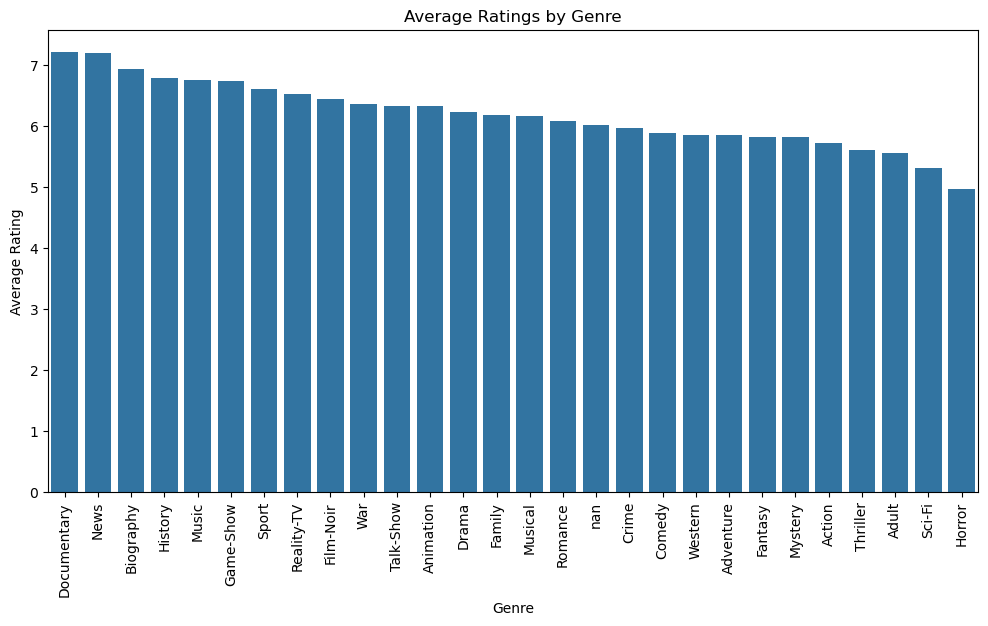

In [6]:

df['genres'] = df['genres'].astype(str)
df['genres'] = df['genres'].str.split(',')  # Split genres
genres_avg_rating = df.explode('genres').groupby('genres')['averageRating'].mean().sort_values(ascending=False)

# Bar Plot for Genres vs Average Rating
plt.figure(figsize=(12, 6))
sns.barplot(x=genres_avg_rating.index, y=genres_avg_rating.values)
plt.xticks(rotation=90)
plt.title('Average Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.show()

2. How does runtime impact the average rating of a movie?

In [17]:
runtime_rating_corr = df[['runtimeMinutes', 'averageRating']].dropna().corr()

print("\nAnalysis: Does Runtime Impact a Movie's Rating?")

# Interpreting the correlation results
if runtime_rating_corr.loc['runtimeMinutes', 'averageRating'] > 0:
    print("There is a positive correlation between runtime and average rating, suggesting that longer films tend to have higher ratings.")
elif runtime_rating_corr.loc['runtimeMinutes', 'averageRating'] < 0:
    print("There is a negative correlation between runtime and average rating, indicating that longer films tend to have lower ratings.")
else:
    print("There is no significant correlation between runtime and average rating, meaning runtime does not impact the movie's rating in any clear way.")

# Printing the correlation value for reference
print("\nCorrelation between runtime and average rating: ")
print(runtime_rating_corr.loc['runtimeMinutes', 'averageRating'])


Analysis: Does Runtime Impact a Movie's Rating?
There is a positive correlation between runtime and average rating, suggesting that longer films tend to have higher ratings.

Correlation between runtime and average rating: 
0.008326469438603637



Analysis: Does Runtime Impact a Movie's Rating?

Correlation between runtime and average rating: 
0.008326469438603637

Average ratings by runtime category:
runtimeCategory
<70 min        6.438245
70-90 min      5.967250
90-120 min     6.117916
120-150 min    6.488764
150-180 min    6.646664
>180 min       6.969902
Name: averageRating, dtype: float64


/var/folders/rn/rs1b20t55p5814zcnfn4wdjc0000gn/T/ipykernel_38867/1937126218.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_ratings_by_runtime = df.groupby('runtimeCategory')['averageRating'].mean()


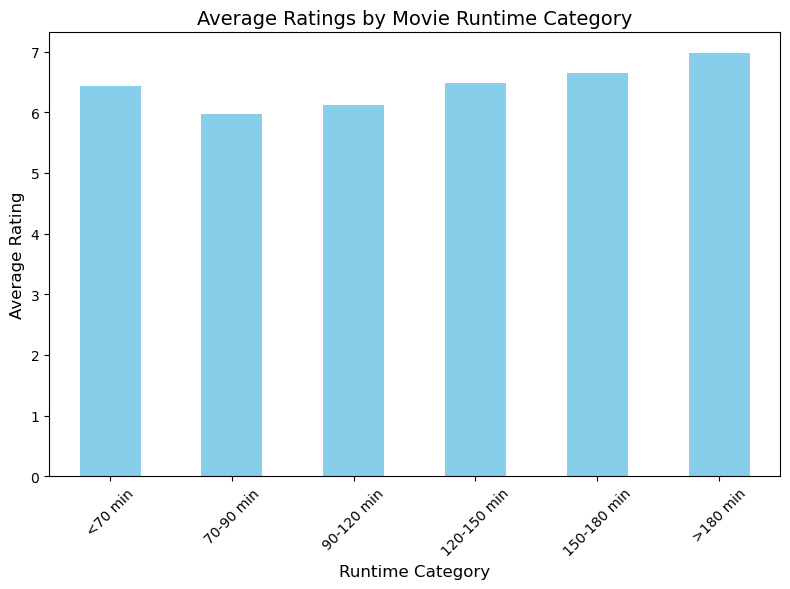

In [19]:
runtime_rating_corr = df[['runtimeMinutes', 'averageRating']].dropna().corr()

print("\nAnalysis: Does Runtime Impact a Movie's Rating?")
print("\nCorrelation between runtime and average rating: ")
print(runtime_rating_corr.loc['runtimeMinutes', 'averageRating'])

# Calculating average ratings by runtime category
runtime_bins = [0, 70, 90, 120, 150, 180, float('inf')]  # Define bins for runtime categories
runtime_labels = ['<70 min', '70-90 min', '90-120 min', '120-150 min', '150-180 min', '>180 min']
df['runtimeCategory'] = pd.cut(df['runtimeMinutes'], bins=runtime_bins, labels=runtime_labels)

# Calculate average rating for each runtime category
avg_ratings_by_runtime = df.groupby('runtimeCategory')['averageRating'].mean()

# Display the average ratings by runtime category
print("\nAverage ratings by runtime category:")
print(avg_ratings_by_runtime)

# Visualization of average ratings by runtime category
import matplotlib.pyplot as plt

# Plotting the average ratings by runtime category
plt.figure(figsize=(8, 6))
avg_ratings_by_runtime.plot(kind='bar', color='skyblue')
plt.title('Average Ratings by Movie Runtime Category', fontsize=14)
plt.xlabel('Runtime Category', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


3. How do the number of votes correlate with a movie’s average rating?

In [79]:
# Analyzing the relationship between the number of votes and average rating
# Let's first clean the data by removing rows with missing values in 'numVotes' and 'averageRating'
filtered_votes_df = df[['numVotes', 'averageRating']].dropna()

# Calculating the correlation between number of votes and average rating
votes_rating_corr = filtered_votes_df.corr()

# Displaying the correlation
print("\nCorrelation between number of votes and average rating:")
print(votes_rating_corr)



Correlation between number of votes and average rating:
               numVotes  averageRating
numVotes       1.000000       0.061308
averageRating  0.061308       1.000000


In [76]:
votes_rating_corr

,numVotes,averageRating
numVotes,1.000000,0.061308
averageRating,0.061308,1.000000


5. Does the Year of Release Affect a Movie’s Average Rating?


Average Ratings by Year of Release (1894-2024):
startYear
1894    5.400000
1896    4.000000
1897    4.800000
1898    3.733333
1899    3.500000
          ...   
2021    6.229239
2022    6.356848
2023    6.402314
2024    6.619172
2025    7.103661
Name: averageRating, Length: 131, dtype: float64


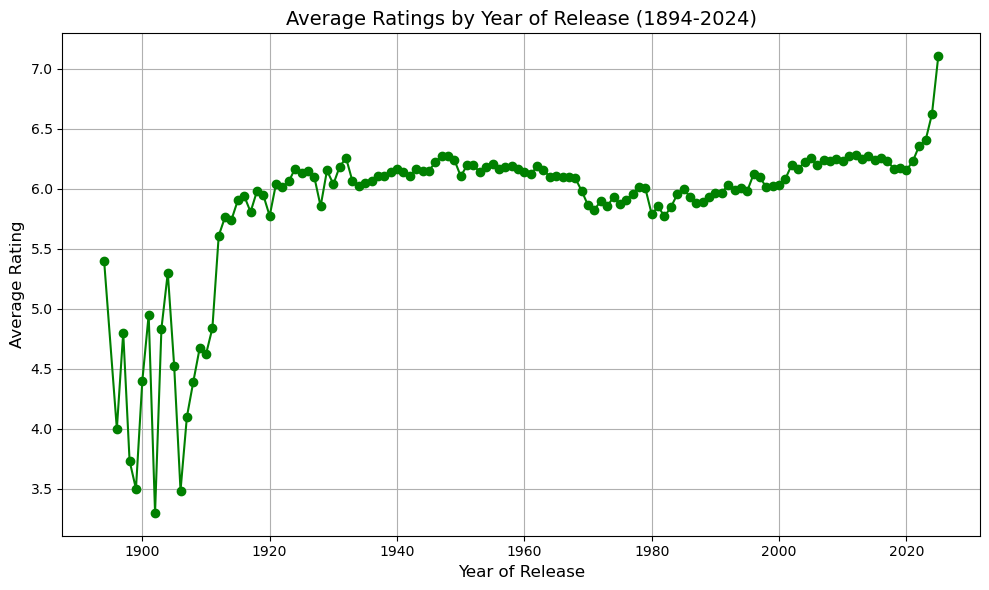

In [72]:
filtered_df = df[(df['startYear'] >= 1894) & (df['startYear'] <= 2025)]

# Analyzing the relationship between the year of release and average rating
# Grouping by the year of release and calculating the average rating for each year
avg_rating_by_year = filtered_df.groupby('startYear')['averageRating'].mean()

# Displaying the results
print("\nAverage Ratings by Year of Release (1894-2024):")
print(avg_rating_by_year)

# Visualizing the average ratings by year
import matplotlib.pyplot as plt

# Plotting the average ratings by year of release
plt.figure(figsize=(10, 6))
avg_rating_by_year.plot(kind='line', color='green', marker='o')
plt.title('Average Ratings by Year of Release (1894-2024)', fontsize=14)
plt.xlabel('Year of Release', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


References:

IMDb Non-Commercial Datasets. (2023). Retrieved from Imdb.com website: https://developer.imdb.com/non-commercial-datasets/